# MultiGroupCAMUV

## Import and settings

In [1]:
import numpy as np
import random
import lingam
from lingam.utils import make_dot

In [2]:
def get_noise(n):
    noise = ((np.random.rand(1, n)-0.5)*5).reshape(n)
    mean = get_random_constant(0.0,2.0)
    noise += mean
    return noise

In [3]:
def causal_func(cause):
    a = get_random_constant(-5.0,5.0)
    b = get_random_constant(-1.0,1.0)
    c = int(random.uniform(2,3))
    return ((cause+a)**(c))+b

In [4]:
def get_random_constant(s,b):
    constant = random.uniform(-1.0, 1.0)
    if constant>0:
        constant = random.uniform(s, b)
    else:
        constant = random.uniform(-b, -s)
    return constant

In [5]:
def create_data(n, n_variables, causal_pairs, intermediate_pairs, confounder_pairs):
    data = np.zeros((n, n_variables)) # observed data
    confounders = np.zeros((n, len(confounder_pairs))) # data of unobserced common causes

    # Adding external effects
    for i in range(n_variables):
        data[:,i] = get_noise(n)
    for i in range(len(confounder_pairs)):
        confounders[:,i] = get_noise(n)
        confounders[:,i] = confounders[:,i] / np.std(confounders[:,i])

    # Adding the effects of unobserved common causes
    for i, cpair in enumerate(confounder_pairs):
        cpair = list(cpair)
        cpair.sort()
        data[:,cpair[0]] += causal_func(confounders[:,i])
        data[:,cpair[1]] += causal_func(confounders[:,i])

    for i1 in range(n_variables)[0:n_variables]:
        data[:,i1] = data[:,i1] / np.std(data[:,i1])
        for i2 in range(n_variables)[i1+1:n_variables+1]:
            # Adding direct effects between observed variables
            if [i1, i2] in causal_pairs:
                data[:,i2] += causal_func(data[:,i1])
            # Adding undirected effects between observed variables mediated through unobserved variables
            if [i1, i2] in intermediate_pairs:
                interm = causal_func(data[:,i1])+get_noise(n)
                interm = interm / np.std(interm)
                data[:,i2] += causal_func(interm)
    
    return data

In [6]:
def make_adjacency_matrix(n_variables, causal_pairs, confounder_pairs, intermediate_pairs):
    B = np.zeros([n_variables, n_variables])
    for pair in causal_pairs:
        B[pair[1], pair[0]] = 1
    for pair in confounder_pairs:
        B[pair[0], pair[1]] = np.nan
        B[pair[1], pair[0]] = np.nan
    for pair in intermediate_pairs:
        B[pair[0], pair[1]] = np.nan
        B[pair[1], pair[0]] = np.nan
    return B

## Data generation

We generate two datasets consisting of 6 variables and 2 latent variable.

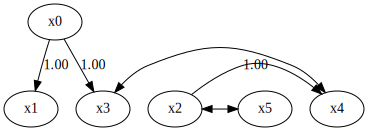

In [7]:
n_variables = 6
causal_pairs = [[0,1],[0,3],[2,4]]
intermediate_pairs = [[2,5]]
confounder_pairs = [[3,4]]

make_dot(make_adjacency_matrix(n_variables, causal_pairs, confounder_pairs, intermediate_pairs))

In [8]:
X1 = create_data(100, n_variables, causal_pairs, intermediate_pairs, confounder_pairs)
X2 = create_data(100, n_variables, causal_pairs, intermediate_pairs, confounder_pairs)
X3 = create_data(100, n_variables, causal_pairs, intermediate_pairs, confounder_pairs)
X_list = [X1, X2, X3]

## Causal Discovery

To run causal discovery for multiple datasets, we create a `MultiGroupCAMUV` object and call the `fit()` method. Using the `adjacency_matrix_` properties, we can see the adjacency matrix as a result of the causal discovery. The coefficients between variables with latent confounders are **np.nan**.

[[ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. nan  0.]
 [ 0.  0.  1. nan  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]]


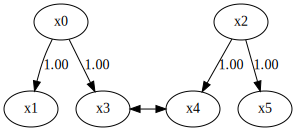

In [9]:
model = lingam.MultiGroupCAMUV()
model.fit(X_list)
print(model._adjacency_matrix)
make_dot(model._adjacency_matrix)

To compare, we run `CAMUV` with single dataset concatenating three datasets. You can see that the causal structure cannot be estimated correctly for a single dataset.

(300, 6)
[[ 0. nan  0.  0.  0.  0.]
 [nan  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.]]


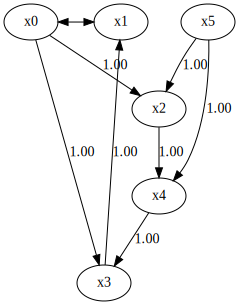

In [10]:
X_all = np.concatenate([X1, X2, X3])
print(X_all.shape)
model = lingam.CAMUV()
model.fit(X_all)
print(model._adjacency_matrix)
make_dot(model._adjacency_matrix)